# Importing the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline


# Loading the data

In [2]:
train_df=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Understanding the data

1. By looking at a sample of the data

In [3]:
pd.set_option('max_columns', 82) # To be able to see all columns
train_df.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1063,1064,30,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,6,6,1925,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,BrkTil,TA,TA,No,BLQ,397,Unf,0,706,1103,GasA,Gd,Y,SBrkr,1103,0,0,1103,0,0,1,0,2,1,Gd,5,Typ,1,Gd,Detchd,1976.0,Unf,2,440,TA,TA,Y,166,120,0,0,0,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal,110500
193,194,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Twnhs,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,Stone,50.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,970,970,GasA,Ex,Y,SBrkr,970,739,0,1709,0,0,2,0,3,1,Gd,7,Maj1,0,NaN,Detchd,2004.0,Unf,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,130000
770,771,85,RL,NaN,7252,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,SFoyer,5,5,1982,1982,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,685,Unf,0,173,858,GasA,TA,Y,SBrkr,858,0,0,858,1,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1983.0,Unf,2,576,TA,TA,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,134900
102,103,90,RL,64.0,7018,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,NaN,Attchd,1979.0,Unf,2,410,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Alloca,118964
904,905,20,RL,NaN,6173,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1967,1967,Gable,CompShg,HdBoard,Wd Sdng,BrkFace,75.0,TA,TA,CBlock,TA,TA,No,GLQ,599,Unf,0,277,876,GasA,TA,Y,SBrkr,902,0,0,902,0,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1967.0,Unf,1,288,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,8,2007,WD,Normal,125500


2. Getting a summary of the data
 a. in terms of the null values present and the data type of each column

In [4]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

b. Statistical summary

In [5]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Understanding the relationship between variables

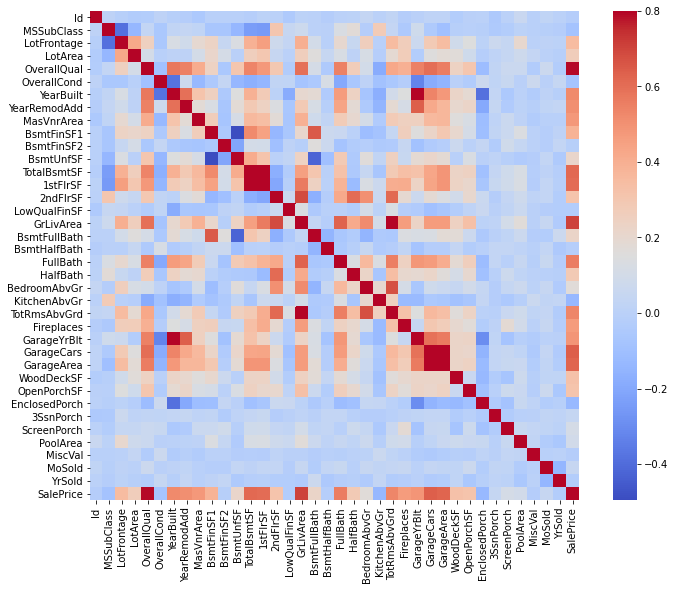

In [6]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap= 'coolwarm'); #

We use heatmaps to visualize the correlation matrix for easier analysis. For this purpose, we look at the squares in red to look at features with possible multicollinearity. The ones we focus on are:
* TotalBsmtSF and 1stFlrSF
* GarageCars, GarageArea
* GarageYrBlt and YearBuilt
* GrLivArea and TotRmsAbvGrd 

Upon further looking at the variables under consideration, we can conclude that they are conveying same information. Like the number of cars that can be parked in a garage (GarageCars) will be directly related to the area occupied by the garage (GarageArea) and thus, having only one of them in the input features set is sufficient for our model. 

Before deciding on which feature to drop, it's better to take a look at the missing data.

# Missing data

In [7]:
n = train_df.shape[0] #number of data points
dum = train_df.isnull().sum()/n #a dictionary containing the number of missing values corresponding to each feature

#check features with possible collinearity
coll_feat = ['TotalBsmtSF','1stFlrSF','GarageCars','GarageArea','GarageYrBlt','YearBuilt','GrLivArea','TotRmsAbvGrd']
print(dum[coll_feat])

TotalBsmtSF     0.000000
1stFlrSF        0.000000
GarageCars      0.000000
GarageArea      0.000000
GarageYrBlt     0.055479
YearBuilt       0.000000
GrLivArea       0.000000
TotRmsAbvGrd    0.000000
dtype: float64


Only GarageYrBlt has missing values. For the rest, we choose to keep the features that describe a more generic quality. As such, the features that we are dropping are: TotalBsmtSF, GarageCars, GarageYrBlt, GrLivArea.

For now we will list these features in an array and further analyze other features with missing data.

# Handling missing Categorical data

In [8]:
coll_feat_drop = ['TotalBsmtSF', 'GarageCars', 'GarageYrBlt', 'GrLivArea']

# For our analysis, we first look at categorical features with missing data
check_cat = [col for col in train_df.columns if dum[col]>0 and train_df[col].dtypes == 'object']
print(check_cat)

['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


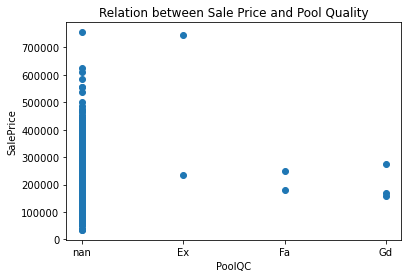

In [11]:
plt.scatter(train_df['PoolQC'].astype(str),train_df['SalePrice'])
plt.title('Relation between Sale Price and Pool Quality')
plt.xlabel('PoolQC')
plt.ylabel('SalePrice')
plt.show()

Some of these categorical features have many missing values simply because that feature is absent for those samples. For example, we know that not all houses have a pool so a missing value in PoolQC which takes values {Gd,Ex,Fa} can be considered as an indicator of the absence of the pool. However, the few samples where this feature is present, it does have an impact of SalePrice. Morever, we know that houses with a pool generally have higher sale price. So, it's better for us to further look into features and assign a new categorical value, NA, if absent than to simply delete the features.

To know if the missing value is really an indicator of the feature not being present, we first list the features that can be absent for a given sample: 
'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'.

Among these features, we group features relevant to basement ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2') and garage ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond') respectively to combine information from relevant features in determining if a basement or a garage is actually absent for the given sample.


In [12]:
#look for samples where all of the basement variables have missing values
print('#samples where all have NaN:',sum(train_df['BsmtCond'].isnull() & train_df['BsmtQual'].isnull() & train_df['BsmtExposure'].isnull() & train_df['BsmtFinType1'].isnull() & train_df['BsmtFinType2'].isnull() ))
print('#samples where BsmtCond has NaN:',sum(train_df['BsmtCond'].isnull()))


#samples where all have NaN: 37
#samples where BsmtCond has NaN: 37


Clearly the samples that have missing values for BsmtCond are the ones with no basement. Let's look at the rest of the samples that are are not in BsmtCond

In [13]:
mask_bsmt = ~train_df['BsmtCond'].isnull() & (train_df['BsmtQual'].isnull() | train_df['BsmtExposure'].isnull() | train_df['BsmtFinType1'].isnull() | train_df['BsmtFinType2'].isnull() )
train_df[mask_bsmt]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000
948,949,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500


Here, we use imputation by their respective mode for these two samples to fill the missing values for BsmtExposure and BsmtFinType2.

In [14]:
train_df.loc[332,'BsmtFinType2'] = (train_df['BsmtFinType2'].mode()[0])
train_df.loc[948,'BsmtExposure'] = (train_df['BsmtExposure'].mode()[0])


For the rest of the missing values in basement variables, we simply replace them with NA to indicate no basement

In [15]:
train_df.fillna({'BsmtCond':'NA','BsmtQual':'NA','BsmtExposure': 'NA','BsmtFinType1':'NA','BsmtFinType2':'NA'}, inplace=True)


Repeat the steps for Garage

In [16]:
#look for samples where all of the garage variables have missing values ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
print('#samples where all have NaN:',sum(train_df['GarageType'].isnull() & train_df['GarageFinish'].isnull() & train_df['GarageQual'].isnull() & train_df['GarageCond'].isnull() ))

#samples where all have NaN: 81


We notice that each of the garage variables also has 81 missing values from the earlier data summary section. Thus, we can conclude that all of the missing values indicate that the garage is absent for that sample and replace them with 'NA'. As this step is to be repeated for the rest of the categorical variables having missing values, we will do them all together in a single step.

On first look, it looks like handling missing values is pretty straight-forward for the rest of the variables in our initial list i.e., if missing, replace with NA to indicate the absence of the feature. However, when we look back at the data, we notice that MasVnrType, FirePlaceQu and PoolQC have numerical features that can give more information about the features.

MasVnrArea and MasVnrType are both related to masonry. If a house has a veneer area, it should also have a masonry veneer type. Thus, we first look at samples with missing values in both MasVnrArea and MasVnrType, and replace them with 0 and NA respectively. 

Let's look into the features for masonry.

In [17]:
print('#samples where both masonry variables have NaN:',sum(train_df['MasVnrType'].isnull() & train_df['MasVnrArea'].isnull()))


#samples where both masonry variables have NaN: 8


Since both features have 8 missing values and they are for the same samples, we can conclude that the missing values represent the absence of masonry.

We thus replace the missing values in all the categorical features with NA and for MasVnrArea, we replace the missing values with 0.

Since both FirePlaces and PoolArea (that relate to FirePlaceQu and PoolQC repectively) do not have any missing values, we first consider all the missing values to indicate absence of the corresponding feature and later verify this using the data in the corresponding numerical features.

In [18]:
list_abs_feat = ['Alley', 'MasVnrType','FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
dict_abs_feat = dict.fromkeys(list_abs_feat,'NA')
dict_abs_feat['MasVnrArea'] = 0
train_df.fillna(dict_abs_feat, inplace=True)

#We replaced the MasVnrType from None to NA for samples having MasVnrArea to be 0 to maintain consistency.
train_df.replace({'MasVnrType':{'None':'NA'}}, inplace=True)


Here, we check that only samples with PoolQC as NA have PoolArea as 0. This is implemented by checking for samples that have PoolQC as NA among the ones with PoolArea not as 0.
Similarly we check to ensure that only samples with FirePlaces as 0 have FirePlaceQu as NA.

In [19]:
mask_PArea = (~train_df['PoolArea']==0) & (train_df['PoolQC']=='NA')
print('For Pools:',sum(mask_PArea))

mask_FPlace = (~train_df['Fireplaces']==0) & (train_df['FireplaceQu']=='NA')
print('For Fireplaces:', sum(mask_FPlace))

For Pools: 0
For Fireplaces: 0


Now, we are left with only one categorical feature with missing values: Electrical. Since this feature cannot be absent for a sample, we simply use imputation by mode to handle the missing values.

In [20]:
train_df['Electrical'].fillna(train_df['Electrical'].mode()[0],inplace=True)

# Handling missing values in numerical data

First, let's check what features still have missing data and by what percent

In [21]:
dum = train_df.isnull().sum()/n
for col in train_df.columns:
    if dum[col]:
        print(col,dum[col]*100)


LotFrontage 17.73972602739726
GarageYrBlt 5.5479452054794525


As GarageYrBlt is in the *coll_feat_drop* list, we only have to look at LotFrontage that has about 18% data missing. 

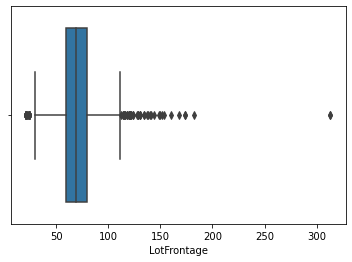

In [22]:
plt.figure()
sns.boxplot(train_df['LotFrontage'])

Because of the clear presence of outliers illustrated in the boxplot, we use imputation by median and not by mean to handle the missing data for LotFrontage.

In [23]:
train_df['LotFrontage'].fillna(train_df['LotFrontage'].median(),inplace=True)

Finally, drop the features with collinearity

In [24]:
train_df.drop(coll_feat_drop, axis=1, inplace=True)

Last Check to ensure there is no missing data

In [25]:
train_df.isnull().sum().sum()

0

# Checking Variables with Ordinal Values

In [26]:
for col in train_df.columns:
    unq = train_df[col].unique()
    if train_df[col].dtype != 'object' and len(unq) <20 :
        print(col, unq)
        print()

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]

OverallQual [ 7  6  8  5  9  4 10  3  1  2]

OverallCond [5 8 6 7 4 2 3 9 1]

BsmtFullBath [1 0 2 3]

BsmtHalfBath [0 1 2]

FullBath [2 1 3 0]

HalfBath [1 0 2]

BedroomAbvGr [3 4 1 2 0 5 6 8]

KitchenAbvGr [1 2 3 0]

TotRmsAbvGrd [ 8  6  7  9  5 11  4 10 12  3  2 14]

Fireplaces [0 1 2 3]

PoolArea [  0 512 648 576 555 480 519 738]

MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]

YrSold [2008 2007 2006 2009 2010]



From the data description, we know the following:
* Variables with numerical data: BedroomAbvGr (number of bedrooms above ground, not including basement bedrooms), KitchenAbvGr, TotRmsAbvGrd, Fireplaces, PoolArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath.
* Variables with ordinal values: OverallQual (rates the overall material and finish of the house), OverallCond (rates the overall condition of the house).
* Others: MoSold, YrSold, MSSubClass - The numerical values associated with these variables are not meaningful. For example, by assigning 1 to January month and 12 to December in MoSold, we are giving a higher priority to December compared to January even though December is not 'better' than January. Thus, we will now convert these variables to categorical.

In [29]:
cat_MSSub = {20:'1 story 1946+', 30:'1 story 1945-', 40:'1 story unf attic', 45:'1,5 story unf', 50:'1,5 story fin', 60:'2 story 1946+', 70:'2 story 1945-', 75:'2,5 story all ages', 80:'split/multi level', 85:'split foyer', 90:'duplex all style/age', 120:'1 story PUD 1946+', 150:'1,5 story PUD all', 160:'2 story PUD 1946+', 180:'PUD multilevel', 190:'2 family conversion'}
cat_Mo = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
train_df.replace({'MSSubClass':cat_MSSub,'MoSold':cat_Mo},inplace=True)
# We will do type conversion to string, to convert the numerical values of YrSold to categorical
train_df['YrSold'] = train_df['YrSold'].astype(str) 


# Encoding Categorical Values

To implement encoding, it is generally important to have domain information to ensure that the categories with ordinal values get the appropriate label encoding.

Here, we first look at the different values each category takes.

In [32]:
for col in train_df:
    if train_df[col].dtype == 'object':
        print(col)
        print(train_df[col].value_counts())
        print()

MSSubClass
1 story 1946+           536
2 story 1946+           299
1,5 story fin           144
1 story PUD 1946+        87
1 story 1945-            69
2 story PUD 1946+        63
2 story 1945-            60
split/multi level        58
duplex all style/age     52
2 family conversion      30
split foyer              20
2,5 story all ages       16
1,5 story unf            12
PUD multilevel           10
1 story unf attic         4
Name: MSSubClass, dtype: int64

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Street
Pave    1454
Grvl       6
Name: Street, dtype: int64

Alley
NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

LotConfig
Inside     1052
Corner      

From the above output, we notice one very odd categorical feature: Utilities. Out of the entire 1460 samples, only one sample has the NoSeWa value while rest of the 1459 samples have AllPub value. With such little information to be gained from the Utlities variable, it does not make sense to have this feature as input to our model.

In [34]:
train_df.drop(['Utilities'], axis=1, inplace=True)

Use *replace* to encode the categories. Here, we created a dictionary that can be used to encode categorical variables describing quality levels (ordinal values)

In [35]:
qual_dict = {'NA':0,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}
lst_qc = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC',]
cat_dict = dict.fromkeys(lst_qc,qual_dict)
train_df.replace(cat_dict,inplace=True)

Among the rest of the categorical data, we look at the features that clearly have ordinal values. They are: GarageFinish, BsmtExposure, BsmtFinType1, BsmtFinType2, Functional.

Let's look at what each of the value in these features mean so they can be appropriately encoded.

**GarageFinish**: Interior finish of the garage
*    Fin - Finished
*    RFn - Rough Finished  
*    Unf - Unfinished
*    NA  - No Garage 
 
 Assigned values: 'None'=0, 'Unf'=1, 'RFn'=2, 'Fin'=3
 
**BsmtExposure**: Refers to walkout or garden level walls
*    Gd - Good Exposure
*    Av - Average Exposure 
*    Mn - Mimimum Exposure
*    No - No Exposure
*    NA - No Basement
 
 Assigned values: 'None'=0, 'No'=1, 'Mn'=2, 'Av'=3, 'Gd'=4
  
**BsmtFinType1/BsmtFinType2**: Rating of basement finished area
*    GLQ - Good Living Quarters
*    ALQ - Average Living Quarters
*    BLQ - Below Average Living Quarters   
*    Rec - Average Rec Room
*    LwQ - Low Quality
*    Unf - Unfinshed
*    NA  - No Basement
  
  Assigned values: 'None'=0, 'Unf'=1, 'LwQ'=2, 'Rec'=3, 'BLQ'=4, 'ALQ'=5, 'GLQ'=6
  
**Functional**: Home functionality
*    Typ  - Typical Functionality
*    Min1 - Minor Deductions 1
*    Min2 - Minor Deductions 2
*    Mod  - Moderate Deductions
*    Maj1 - Major Deductions 1
*    Maj2 - Major Deductions 2
*    Sev  - Severely Damaged
*    Sal  - Salvage only
  
  Assigned values: 'Sal'=0, 'Sev'=1, 'Maj2'=2, 'Maj1'=3, 'Mod'=4, 'Min2'=5, 'Min1'=6, 'Typ'=7
  
**Street**: Type of road access to property

*    Grvl - Gravel  
*    Pave - Paved

  Assigned values: 'Grvl'=0, 'Pave'=1
  
**PavedDrive**: Paved driveway

*    Y    Paved 
*    P    Partial Pavement
*    N    Dirt/Gravel
   
   Assigned values: 'N'=0, 'P'=1, 'Y'=2

In [36]:
gar_fin = {'None':0, 'Unf':1, 'RFn':2, 'Fin':3}
bsmt_exp = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
bsmt_fin = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
home_func = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
strt = {'Grvl':0, 'Pave':1}
pvd_drv = {'N':0,'P':1,'Y':2}
ord_dict = {'GarageFinish':gar_fin, 'BsmtExposure':bsmt_exp,'BsmtFinType1':bsmt_fin, 'BsmtFinType2':bsmt_fin, 'Functional': home_func,'Street':strt,'PavedDrive':pvd_drv}

train_df.replace(ord_dict, inplace=True)

Use get_dummies to do One-Hot Encoding for the rest of the categorical variables

In [37]:
dum_cat = [col for col in train_df.columns if train_df[col].dtype == 'object' ]
train_df = pd.get_dummies(train_df)

In [38]:
#applying log transformation
train_df['SalePrice'] = np.log(train_df['SalePrice'])